# Eva 02

## prepare

In [1]:
from os import path
import matplotlib.pyplot as plt
from PIL import Image
import torch
import sys
sys.path.append('/data/ruip/eva02/gill-main_2/demo/') 
# from modelscope.models import Model
# from modelscope.pipelines import pipeline
# from modelscope.preprocessors import Preprocessor
# from modelscope.utils.constant import Tasks
import models
from act_compute import find_token, deal_img, find_eva_act, save_output_img, generate_for_prompt
from modelscope.hub.snapshot_download import snapshot_download
from detectron2.config import get_cfg, LazyConfig
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger

from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer


/data/ruip/eva/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/ruip/eva/lib/python3.9/site-packages/gradio_client/documentation.py:103: UserWarning: Could not get documentation group for <class 'gradio.mix.Parallel'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")
/data/ruip/eva/lib/python3.9/site-packages/gradio_client/documentation.py:103: UserWarning: Could not get documentation group for <class 'gradio.mix.Series'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")
2024-05-06 20:08:11,179 - modelscope - INFO - PyTorch version 2.0.1+cu117 Found.
2024-05-06 20:08:11,182 - modelscope - INFO - Loading ast index from /home/ruip/.cache/modelscope/ast_i

In [2]:
# base_url = r'/mnt/workspace'
base_url = r'/data/ruip/'
# ckpt_base_pth = path.join(base_url, 'model')
ckpt_base_pth = path.join(base_url, 'eva02')
data_base_path = path.join(base_url, "data")

# eva02_base_path = '/mnt/workspace/model/zacbi2023/eva02'
gill_input_path = '/data/ruip/eva02/test_dog_data1'
gill_output_path = '/data/ruip/data/image/output/'
eva02_base_path = '/data/ruip/eva02/eva/eva02'
gill_base_path = '/data/ruip/eva02/gill-main_2/checkpoints/gill_opt'
eva02_config_path = path.join(eva02_base_path, 'projects/ViTDet/configs/eva2_o365_to_coco/eva2_o365_to_coco_cascade_mask_rcnn_vitdet_l_8attn_1536_lrd0p8.py')
eva02_weights_path = path.join(eva02_base_path, 'checkpoints/eva02_L_coco_seg_sys_o365.pth') 
# no influence
input_image_path = path.join(data_base_path, '/data/ruip/data/image/output/')
output_dir = path.join(data_base_path, '/data/ruip/data/image/ev02_output/')

# eva02_model_id = r'zacbi2023/eva02'
eva02_model_id = r'/eva/eva02'
eva02_ckpt_path = path.join(ckpt_base_pth, eva02_model_id)

### download model

In [3]:
if not path.exists(eva02_base_path):
    snapshot_download('zacbi2023/eva02', cache_dir = ckpt_base_pth, ignore_file_pattern='eva02_L_ade_seg_upernet_sz640.pth')

### config base

In [4]:
config_file = eva02_config_path
custum_cfg = ['MODEL.RETINANET.SCORE_THRESH_TEST', 0.5,
              'MODEL.ROI_HEADS.SCORE_THRESH_TEST', 0.5,
              'MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH', 0.5,
              'DATASETS.TEST', [],
            'MODEL.WEIGHTS', eva02_weights_path]

### load via LazyConfig

In [5]:
cfg = LazyConfig.load(config_file)
LazyConfig.apply_overrides(cfg, [f"{key}={value}" for key, value in zip(custum_cfg[::2], custum_cfg[1::2])])

{'dataloader': {'train': {'dataset': {'names': 'coco_2017_train', '_target_': <function get_detection_dataset_dicts at 0x7f2cf126be50>}, 'mapper': {'is_train': True, 'augmentations': [{'horizontal': True, '_target_': <class 'detectron2.data.transforms.augmentation_impl.RandomFlip'>}, {'min_scale': 0.1, 'max_scale': 2.0, 'target_height': 1536, 'target_width': 1536, '_target_': <class 'detectron2.data.transforms.augmentation_impl.ResizeScale'>}, {'crop_size': [1536, 1536], 'pad': False, '_target_': <class 'detectron2.data.transforms.augmentation_impl.FixedSizeCrop'>}], 'image_format': 'RGB', 'use_instance_mask': True, '_target_': <class 'detectron2.data.dataset_mapper.DatasetMapper'>, 'recompute_boxes': True}, 'total_batch_size': 64, 'num_workers': 4, '_target_': <function build_detection_train_loader at 0x7f2cf126f160>}, 'test': {'dataset': {'names': 'coco_2017_val', 'filter_empty': False, '_target_': <function get_detection_dataset_dicts at 0x7f2cf126be50>}, 'mapper': {'is_train': Fals

load gill model

In [6]:
gill_model = models.load_gill(gill_base_path)

1

2

3

4

5
,gogogoogogo
5

Adding [IMG0] token to vocabulary.
Before adding new token, tokenizer("[IMG0]") = {'input_ids': [10975, 3755, 534, 288, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG0]") = {'input_ids': [50266], 'attention_mask': [1]}
Adding [IMG1] token to vocabulary.
Before adding new token, tokenizer("[IMG1]") = {'input_ids': [10975, 3755, 534, 134, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG1]") = {'input_ids': [50267], 'attention_mask': [1]}
Adding [IMG2] token to vocabulary.
Before adding new token, tokenizer("[IMG2]") = {'input_ids': [10975, 3755, 534, 176, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IMG2]") = {'input_ids': [50268], 'attention_mask': [1]}
Adding [IMG3] token to vocabulary.
Before adding new token, tokenizer("[IMG3]") = {'input_ids': [10975, 3755, 534, 246, 742], 'attention_mask': [1, 1, 1, 1, 1]}
After adding 1 new tokens, tokenizer("[IM

/data/ruip/eva/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.12s/it]


9

8

Freezing the LM.
Restoring pretrained weights for the visual model.


Some weights of the model checkpoint at /data/ruip/eva02/gill-main_2/transformer_cache/visual were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.11.self_attn.v_proj.bias', 'text_model.encoder.layers.8.self_attn.v_proj.weight', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.1.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.1.self_attn.k_proj.bias', 'text_model.encoder.layers.3.layer_norm1.weight', 'text_model.encoder.layers.4.mlp.fc1.bias', 'text_model.encoder.layers.4.layer_norm2.weight', 'text_model.encoder.layers.7.self_attn.v_proj.weight', 'visual_projection.weight', 'text_model.encoder.layers.3.self_attn.v_proj.weight', 'text_model.encoder.layers.5.self_attn.q_proj.weight', 'text_model.encoder.layers.11.self_attn.v_proj.weight', 'text_model.encoder.layers.4.layer_norm1.bias', 'text_model.encoder.layers.5.layer_norm1.weight', 'text_model.final_layer_norm.bias', 'text_mod

10

Freezing the VM.
11

12

13



`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


14

Loading decision model...
7



/data/ruip/eva02/gill-main_2/demo/models.py:1012: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb_matrix = torch.tensor(emb_matrix, dtype=logit_scale.dtype).to(logit_scale.device)


get gill output

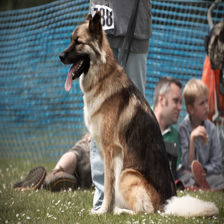

1
Running model.generate_for_images_and_texts with [<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2DCC80E100>, 'Q: What is this ?\nA:']
input_embs:**** torch.Size([1, 14, 4096])
ret_idx 5


100%|██████████| 50/50 [00:02<00:00, 19.10it/s]


very important: tensor([[ 152,   16,   10, 2335,  479]], device='cuda:0')
very important:  This is a dog.
*********ret_id 5
model_outputs [' This is a dog. [IMG0][IMG1][IMG2][IMG3][IMG4][IMG5][IMG6][IMG7]', {'gen': [(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F2DA8287D30>, 0.61328125)], 'ret': [(<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2DA8309160>, 'ret', 10.5), (<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2DA838ED90>, 'ret', 10.1875), (<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2DA82878E0>, 'ret', 10.1875)], 'decision': ['ret', [0.000579833984375, 1.0]]}] 1.0
['ĠThis', 'Ġis', 'Ġa', 'Ġdog', '.', 'Ġ', '[IMG0]', '[IMG1]', '[IMG2]', '[IMG3]', '[IMG4]', '[IMG5]', '[IMG6]', '[IMG7]']
[2, 152, 16, 10, 2335, 4, 1437, 50266, 50267, 50268, 50269, 50270, 50271, 50272, 50273]
[' This is a dog. [IMG0][IMG1][IMG2][IMG3][IMG4][IMG5][IMG6][IMG7]', {'gen': [(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F2DA8287D30>, 0.61328125)], 'ret': [(<PIL.Image.Image imag

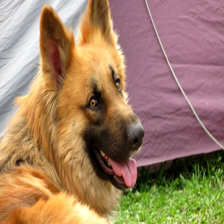

In [7]:
input_text = "What is this ?"
file_list = deal_img(gill_input_path)
model_input = []
# 例如要处理路径中的第1张图片
file_list[0].show()
model_input.append(file_list[0])
print(len(model_input))
with torch.no_grad():
    model_output = generate_for_prompt(gill_model, input_text, model_input, ret_scale_factor=1.0, num_words=32, temperature=0.0)
print(model_output)
model_output1 = save_output_img(model_output, gill_output_path, index=0) # 输出文件夹的0索引表示的图片
model_input.clear()

find the tenth top act

In [8]:
input_text1  = "What is this ?"
find_eva_act(gill_model, gill_input_path, input_text1, ret_scale_factor=1.0, num_words=32, temperature=0.0)

<class 'str'>
<class 'str'>
<class 'str'>
Running model.generate_for_images_and_texts with []
input_embs:**** torch.Size([1, 14, 4096])
ret_idx 5


100%|██████████| 50/50 [00:02<00:00, 20.12it/s]


very important: tensor([[ 152,   16,   10, 2335,  479]], device='cuda:0')
very important:  This is a dog.
*********ret_id 5
[' This is a dog. [IMG0][IMG1][IMG2][IMG3][IMG4][IMG5][IMG6][IMG7]', {'gen': [(<PIL.Image.Image image mode=RGB size=512x512 at 0x7F2DA836FAC0>, 0.6171875)], 'ret': [(<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2DA8307D30>, 'ret', 10.5), (<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2DA838C7F0>, 'ret', 10.1875), (<PIL.Image.Image image mode=RGB size=224x224 at 0x7F2C2A88CE20>, 'ret', 10.1875)], 'decision': ['ret', [0.000579833984375, 1.0]]}]
code: 16319
code_text:  [2, 152, 16, 10, 2335, 4, 1437, 50266, 50267, 50268, 50269, 50270, 50271, 50272, 50273]
5
[[(0, 2937), (0, 14117), (0, 1323), (0, 15283), (0, 7229), (0, 4361), (0, 14446), (0, 10084), (0, 8735), (0, 15578)], [(1, 13354), (1, 13501), (1, 3434), (1, 3212), (1, 9248), (1, 10810), (1, 1496), (1, 13522), (1, 155), (1, 10296)], [(2, 3087), (2, 4990), (2, 5804), (2, 6996), (2, 2999), (2, 5820), (

another method test2.py

### load via get_cfg()

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(config_file)
cfg.merge_from_list([f"{key}={value}" for key, value in zip(custum_cfg[::2], custum_cfg[1::2])])

## Infer

In [ ]:
from detectron2.config import instantiate
model = instantiate(cfg.model)
model.to('cuda')

In [ ]:
from detectron2.checkpoint import DetectionCheckpointer
DetectionCheckpointer(model).load(eva02_weights_path)
model.eval()

In [ ]:
original_image = read_image(path.join(gill_output_path,"dog0.jpg"), format="BGR")
height, width = original_image.shape[:2]
image = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))
inputs = {"image": image, "height": height, "width": width}
predictions = model([inputs])[0]

In [ ]:
original_image = original_image[:, :, ::-1]

In [ ]:
# 可视化器
visualizer = Visualizer(original_image, None,
                                instance_mode=ColorMode.IMAGE)

In [ ]:
cpu_device = torch.device("cpu")
instances = predictions["instances"].to(cpu_device)

In [ ]:
# 可视化输出
vis_output = visualizer.draw_instance_predictions(
                    predictions=instances)

In [ ]:
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
vis_output.save(path.join(output_dir, 'dog001.jpg'))